In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path

from image2image_io.readers import get_simple_reader, ArrayImageReader
from valis.warp_tools import numpy2vips, vips2numpy

import matplotlib.pyplot as plt
import numpy as np
from koyo.timer import MeasureTimer

from image2image_wsireg.valis.slide_io import Image2ImageSlideReader
from image2image_io.writers import write_ome_tiff_from_array

from valis.registration import Valis
# from image2image_wsireg.valis.register import Valis
from loguru import logger
import pickle

logger.enable("image2image_wsireg")

/Users/lgmigas/Documents/GitHub/image2image/venv/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


In [3]:
base_dir = Path(r"/Users/lgmigas/Dropbox/_CACHE_/2024_03_11_coburn_xenium_ims")

In [4]:
xenium_path = base_dir / "xenium2t-he_registered.ome.tiff"
# xenium_reader = get_simple_reader(xenium_path)

In [5]:
ims_path = base_dir / "ims2a-he_to_postaf_registered.ome.tiff"
# ims_reader = get_simple_reader(ims_path)

In [6]:
results_dir = base_dir / "registrations"
results_dir.mkdir(exist_ok=True)
name = "xenium2ims"
short_filelist = [
    str(xenium_path),
    str(ims_path),
]

In [7]:
pickle_list = list((results_dir / name / "data").glob("*.pickle"))
if pickle_list:
    with open(pickle_list[0], "rb") as f:
        registrar = pickle.load(f)
registrar

In [7]:
registrar = Valis(
    str(base_dir),
    str(results_dir),
    name=name,
    # micro_rigid_registrar_cls=MicroRigidRegistrar,
    # image_type="fluorescence",
    imgs_ordered=True,
    img_list=short_filelist,
    reference_img_f=str(ims_path),
    align_to_reference=True,
    check_for_reflections=True,
)

In [8]:
registrar.rigid_reg_kwargs

{'name': 'xenium2ims',
 'feature_detector': <valis.feature_detectors.VggFD at 0x11e26a250>,
 'similarity_metric': 'n_matches',
 'transformer': <SimilarityTransform(matrix=
     [[ 1.,  0.,  0.],
      [ 0.,  1.,  0.],
      [ 0.,  0.,  1.]]) at 0x2d1c14a60>,
 'matcher': <valis.feature_matcher.Matcher at 0x2d1af3040>,
 'affine_optimizer': None,
 'reference_img_f': '/Users/lgmigas/Dropbox/_CACHE_/2024_03_11_coburn_xenium_ims/ims2a-he_to_postaf_registered.ome.tiff',
 'imgs_ordered': True,
 'check_for_reflections': True,
 'qt_emitter': None}

In [9]:
with MeasureTimer() as timer:
    rigid_registrar, non_rigid_registrar, error_df = registrar.register(reader_cls=Image2ImageSlideReader)
print(f"Registered low-res images in {timer()}")


==== Converting images


Converting images:   0%|          | 0/2 [00:00<?, ?image/s]
/Users/lgmigas/Documents/GitHub/valis/valis/valtils.py:22: UserWarning: 'Array' object has no attribute 'data'
  warnings.warn(warning_msg, warning_type)


Traceback (most recent call last):
  File "/Users/lgmigas/Documents/GitHub/valis/valis/registration.py", line 4102, in register
    self.convert_imgs(series=self.series, reader_cls=reader_cls)
  File "/Users/lgmigas/Documents/GitHub/valis/valis/registration.py", line 2302, in convert_imgs
    vips_img = reader.slide2vips(level=level)
  File "/Users/lgmigas/Documents/GitHub/image2image-reg/src/image2image_wsireg/valis/slide_io.py", line 43, in slide2vips
    return numpy2vips(img)
  File "/Users/lgmigas/Documents/GitHub/valis/valis/slide_tools.py", line 109, in numpy2vips
    vi = pyvips.Image.new_from_memory(linear.data, width, height, bands,
AttributeError: 'Array' object has no attribute 'data'

JVM has been killed. If this was due to an error, then a new Python session will need to be started
Registered low-res images in 156ms 115μs


In [29]:
# Calculate what `max_non_rigid_registration_dim_px` needs to be to do non-rigid registration on an image that is 25% full resolution.
micro_reg_fraction = (
    0.25  # Fraction full resolution used for non-rigid registration
)
try:
    img_dims = np.array(
        [
            slide_obj.slide_dimensions_wh[0]
            for slide_obj in registrar.slide_dict.values()
        ]
    )
    min_max_size = np.min([np.max(d) for d in img_dims])
    img_areas = [np.multiply(*d) for d in img_dims]
    max_img_w, max_img_h = tuple(img_dims[np.argmax(img_areas)])
    micro_reg_size = np.floor(min_max_size * micro_reg_fraction).astype(int)
except Exception as exc:
    micro_reg_size = 5000  # 5k pixels
    
# Perform high resolution non-rigid registration
with MeasureTimer() as timer:
    try:
        micro_reg, micro_error = registrar.register_micro(
            max_non_rigid_registration_dim_px=micro_reg_size
        )
    except Exception as exc:
        print(f"Error during non-rigid registration: {exc}")
print(f"Registered high-res images in {timer()}")

Preparing images for non-rigid registration: 100%|██████████| 2/2 [00:03<00:00,  1.81s/image]



==== Performing microregistration


Finding non-rigid transforms: 100%|██████████| 1/1 [00:04<00:00,  4.25s/image]



======== Non-rigid registration complete in 4.434 seconds

==== Measuring error


Measuring error: 100%|██████████| 2/2 [00:00<00:00,  8.85image/s]


Registered high-res images in 8s 928ms


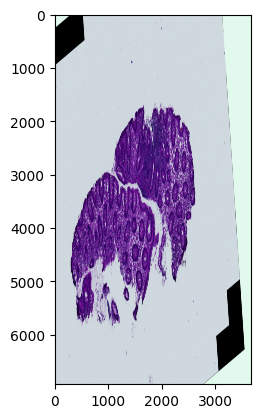

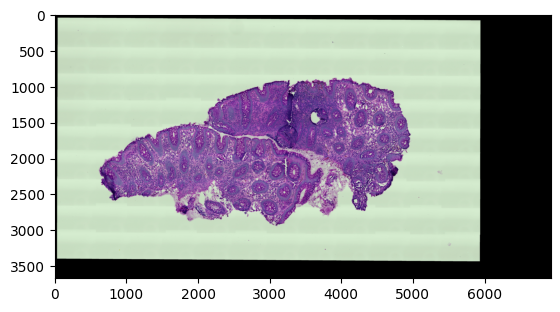

In [30]:
for slide_obj in registrar.slide_dict.values():
    warped = slide_obj.warp_slide(
        level=0, 
        non_rigid=False,
        interp_method="nearest",
        crop="reference",
        # src_f=slide_obj.src_f
    )
    plt.figure()
    plt.imshow(warped, aspect=1)

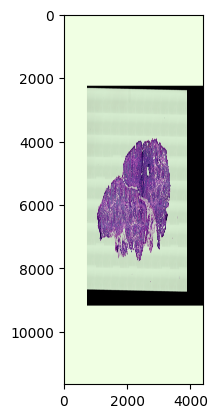

In [23]:
warped = slide_obj.warp_slide(
    level=0, 
    interp_method="nearest",
    crop="all"
)
plt.imshow(warped)

In [34]:
for slide_obj in registrar.slide_dict.values():
    warped = slide_obj.warp_slide(
        level=0, 
        interp_method="nearest",
        crop="reference"
    )
    print(slide_obj.reader.slide2vips(), warped)

<pyvips.Image 21788x14174 uchar, 3 bands, srgb> <pyvips.Image 3672x6927 uchar, 3 bands, srgb>
<pyvips.Image 6927x3672 uchar, 3 bands, srgb> <pyvips.Image 6927x3672 uchar, 3 bands, srgb>


In [20]:
for slide_obj in registrar.slide_dict.values():
    warped = slide_obj.warp_slide(
        level=0, 
        interp_method="nearest",
        # crop="reference"
    )
    print(warped)
    # print(slide_obj.reg_img_shape_rc)

<pyvips.Image 3672x6927 uchar, 3 bands, srgb>
<pyvips.Image 6927x3672 uchar, 3 bands, srgb>


In [21]:
# export images to OME-TIFFs
output_dir = (Path(registrar.dst_dir) / "registered")
output_dir.mkdir(exist_ok=True, parents=True)

ref_slide = registrar.get_ref_slide()
for slide_obj in registrar.slide_dict.values():
    reader = get_simple_reader(slide_obj.src_f)
    output_filename = output_dir / reader.path.name
    # if output_filename.exists():
    #     continue

    warped = slide_obj.warp_slide(
        level=0, 
        interp_method="nearest",
        crop=False
        # crop="reference"
    )
    warped = vips2numpy(warped)
    print(warped.shape)

    write_ome_tiff_from_array(
        output_filename,
        None,
        warped,
        resolution=ref_slide.resolution,
        channel_names=reader.channel_names
    )

(11658, 4385, 3)


2024-03-11 14:25:45.851 | INFO     | image2image_io.writers.tiff_writer:write_image_by_plane:231 - Saving to '/Users/lgmigas/Dropbox/_CACHE_/2024_03_11_coburn_xenium_ims/registrations/xenium2ims/registered/xenium2t-he_registered.ome.tiff'
2024-03-11 14:25:45.851 | INFO     | image2image_io.writers.tiff_writer:_prepare_image_info:178 - Saving using jpeg compression
2024-03-11 14:25:45.852 | INFO     | image2image_io.writers.tiff_writer:write_image_by_plane:257 - Writing channels ids: [0, 1, 2]
2024-03-11 14:25:45.852 | INFO     | image2image_io.writers.tiff_writer:write_image_by_plane:258 - Writing channels: ['R', 'G', 'B']
2024-03-11 14:25:45.970 | INFO     | image2image_io.writers.tiff_writer:write_image_by_plane:369 - Writing pyramid...
2024-03-11 14:25:45.982 | INFO     | image2image_io.writers.tiff_writer:write_image_by_plane:373 - pyramid index 1 : shape: (2192, 5829)
2024-03-11 14:25:46.005 | INFO     | image2image_io.writers.tiff_writer:write_image_by_plane:373 - pyramid index 2

(11658, 4385, 3)


2024-03-11 14:25:46.491 | INFO     | image2image_io.writers.tiff_writer:write_image_by_plane:231 - Saving to '/Users/lgmigas/Dropbox/_CACHE_/2024_03_11_coburn_xenium_ims/registrations/xenium2ims/registered/ims2a-he_to_postaf_registered.ome.tiff'
2024-03-11 14:25:46.492 | INFO     | image2image_io.writers.tiff_writer:_prepare_image_info:178 - Saving using jpeg compression
2024-03-11 14:25:46.492 | INFO     | image2image_io.writers.tiff_writer:write_image_by_plane:257 - Writing channels ids: [0, 1, 2]
2024-03-11 14:25:46.492 | INFO     | image2image_io.writers.tiff_writer:write_image_by_plane:258 - Writing channels: ['R', 'G', 'B']
2024-03-11 14:25:46.610 | INFO     | image2image_io.writers.tiff_writer:write_image_by_plane:369 - Writing pyramid...
2024-03-11 14:25:46.622 | INFO     | image2image_io.writers.tiff_writer:write_image_by_plane:373 - pyramid index 1 : shape: (2192, 5829)
2024-03-11 14:25:46.646 | INFO     | image2image_io.writers.tiff_writer:write_image_by_plane:373 - pyramid 

In [20]:
for slide_obj in registrar.slide_dict.values():
    reader = get_simple_reader(slide_obj.src_f)
    print(reader.shape)

(14174, 21788, 3)
(3672, 6927, 3)


In [44]:
ArrayImageReader(
    None,
    warped,
    resolution=
)

PosixPath('/Users/lgmigas/Dropbox/_CACHE_/2024_03_11_coburn_xenium_ims/registrations/xenium2ims/registered')

In [40]:
warped = slide_obj.warp_slide(
    level=0, 
    interp_method="nearest",
    crop="reference"
)
warped = vips2numpy(warped)
warped.shape

2024-03-11 13:34:17.804 | WARNING  | image2image_io.readers.tiff_reader:_get_channel_names:121 - Number of channels (3) does not match number of channel names ([])


(3672, 6927, 3)

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from koyo.timer import MeasureTimer

import valis
from natsort import natsorted
from valis import slide_tools
from valis import registration
from valis.micro_rigid_registrar import (
    MicroRigidRegistrar,
)  # For high resolution rigid registration

from image2image_io.writers import OmeTiffWriter, write_ome_tiff_from_array
from image2image_io.readers import ArrayImageReader, get_simple_reader

# initialize java
valis.registration.init_jvm()

ome_tiff = Path(
    r"\\145.94.60.12\vandeplaslab\__TEMP__\__Lukasz__\2024_xenium_reg_2\GCA035_FrozenACB_2-2"
)
results_dir = ome_tiff / "registrations"
results_dir.mkdir(exist_ok=True)
registered_dir = results_dir / "registered"
registered_dir.mkdir(exist_ok=True)

xenium_he = ome_tiff / r"xenium2t-he_registered.ome.tiff"

ims_he = ome_tiff / r"ims2a-he_to_postaf_registered.ome.tiff"

filelist = [xenium_he, ims_he]

# ranges
short_filelist = filelist
short_filelist = [str(s) for s in short_filelist]
print(short_filelist)

name = f"xenium_n={len(filelist)}"
print(name)
try:
    # Perform high resolution rigid registration using the MicroRigidRegistrar
    registrar = registration.Valis(
        str(ome_tiff),
        str(results_dir),
        name=name,
        # micro_rigid_registrar_cls=MicroRigidRegistrar,
        # image_type="fluorescence",
        imgs_ordered=True,
        img_list=short_filelist,
        reference_img_f=str(ims_he),
        align_to_reference=True,
        check_for_reflections=True,
    )

    with MeasureTimer() as timer:
        rigid_registrar, non_rigid_registrar, error_df = registrar.register()
    print(f"Registered low-res images in {timer()}")

    # Calculate what `max_non_rigid_registration_dim_px` needs to be to do non-rigid registration on an image that is 25% full resolution.
    micro_reg_fraction = (
        0.25  # Fraction full resolution used for non-rigid registration
    )
    try:
        img_dims = np.array(
            [
                slide_obj.slide_dimensions_wh[0]
                for slide_obj in registrar.slide_dict.values()
            ]
        )
        min_max_size = np.min([np.max(d) for d in img_dims])
        img_areas = [np.multiply(*d) for d in img_dims]
        max_img_w, max_img_h = tuple(img_dims[np.argmax(img_areas)])
        micro_reg_size = np.floor(min_max_size * micro_reg_fraction).astype(int)
    except Exception as exc:
        micro_reg_size = 5000  # 5k pixels

    # Perform high resolution non-rigid registration
    with MeasureTimer() as timer:
        try:
            micro_reg, micro_error = registrar.register_micro(
                max_non_rigid_registration_dim_px=micro_reg_size
            )
        except Exception as exc:
            print(f"Error during non-rigid registration: {exc}")
    print(f"Registered high-res images in {timer()}")

    # export images to OME-TIFFs
    for slide_obj in registrar.slide_dict.values():
        reader = get_simple_reader(slide_obj.src_f)
        output_filename = registered_dir / reader.path.name
        if output_filename.exists():
            continue

        warped = slide_obj.warp_slide(level=0, interp_method="nearest")
        if not isinstance(warped, np.ndarray):
            warped = slide_tools.vips2numpy(warped)

        write_ome_tiff_from_array(
            output_filename, reader, warped
        )  # np.moveaxis(warped, 2, 0))

    # We can also plot the high resolution matches using `Valis.draw_matches`:
    matches_dst_dir = Path(registrar.dst_dir) / "matches"
    registrar.draw_matches(matches_dst_dir)
except Exception as exc:
    registration.kill_jvm()
    raise exc
registration.kill_jvm()
